In [1]:
import os
import pandas as pd
import h5py
import numpy as np
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM 
from statsmodels.stats.multicomp import pairwise_tukeyhsd
sns.set_theme()
sns.set_style("white")
sns.set_context("notebook")
sns.set_palette("Paired")

In [2]:
# Read in training data
current_directory = os.getcwd()

data = []

# participants
participants = ('SN001', 'SN002', 'SN003', 'SN004', 'SN005', 'SN006', 'SN007', 'SN008', 'SN009', 'SN010', 'SN012', 'SN013', 'SN014', 'SN015', 'SN016', 'SN017', 'SN018', 'SN019', 'SN020', 'SN021')

results=[]
SN=0
for p in participants:
    SN = SN+1
    root_subject = os.path.join('data', p)
    control_folders = [f.path for f in os.scandir(root_subject) if f.is_dir() and f.name.startswith('control')]
    BN = 0
    for b in control_folders:
        BN += 1
        if os.path.isfile(os.path.join(b, 'trials.csv')):
            trials = pd.read_csv(os.path.join(b, 'trials.csv'))
            
            # plt.figure(figsize=(10, 5))

            if trials["emg"][0] == 1: 
                if os.path.isfile(os.path.join(b, 'data_proc.hdf5')):
                    data_proc = h5py.File(os.path.join(b, 'data_proc.hdf5'), 'r')
                

                proc_1 = np.array(data_proc['1'][:][0])
                proc_2 = np.array(data_proc['1'][:][1])
                
                # li at al. paper CCI 1 (numpy min max calc)
                # cocontract v noise
                # cocontract block 2 v 4 1 v 3
                # li et al paper contraction over time
                # one big df all trials all timepoints with each calculated cocontract
                    
                cocontraction = np.zeros(proc_1.shape)
                    
                for i in range(proc_1.shape[0]):
                    inputlow = min(abs(proc_1[i]), abs(proc_2[i]))
                    inputhigh = max(abs(proc_1[i]), abs(proc_2[i]))
                    
                    if inputhigh != 0:
                        cocontraction[i] = (inputlow / inputhigh) * (inputhigh + inputlow)
                    else:
                        cocontraction[i] = 0 
                        
                
                time_points = np.arange(proc_1.shape[0])
               
                    # combined_signal = proc_1 + proc_2
                    # cocontract = (proc_1 > 0.2) & (proc_2 > 0.2)
                    # max_combined_signal = np.max(combined_signal[cocontract]) if np.any(cocontract) else 0
                    # cocontract_time = np.sum(cocontract)

                results.append({
                    "Participant": [SN] * len(time_points),
                    'Block': [BN] * len(time_points),
                    'TimePoint': time_points,
                    'Cocontraction': cocontraction
                    # "Noise": noise_level,
                    # "MaxCombinedSignal": max_combined_signal,
                    # "CocontractionTime": cocontract_time
                })
                    
                    # sns.lineplot(data=proc_1[50:200])
                    # sns.lineplot(data=proc_2[50:200], linestyle='dashed')
                    # plt.xlabel('Time (s)', fontsize=16)
                    # plt.ylabel('Amplitude (V)', fontsize=16)
                    # plt.title(f'Participant {SN} Block {BN}')
                    # plt.xticks(ticks=[0, 40, 80, 120, 160], labels=[0, 2, 4, 6, 8])                
                    # sns.despine()

results_df = pd.DataFrame(results)
# results_df

In [3]:
participant_list = []
block_list = []
timepoint_list = []
cocontraction_list = []


for index, row in results_df.iterrows():
    participant = row['Participant'][0]
    block = row['Block'][0] 
    time_points = row['TimePoint']
    cocontraction = row['Cocontraction']
    
   
    participant_list.extend([participant] * len(time_points))
    block_list.extend([block] * len(time_points))
    timepoint_list.extend(time_points)
    cocontraction_list.extend(cocontraction)


flat_results_df = pd.DataFrame({
    'Participant': participant_list,
    'Block': block_list,
    'TimePoint': timepoint_list,
    'Cocontraction': cocontraction_list
})

#print(flat_results_df)


In [4]:
def calculate_cocontraction(proc_1, proc_2):
    inputlow = np.minimum(np.abs(proc_1), np.abs(proc_2))
    inputhigh = np.maximum(np.abs(proc_1), np.abs(proc_2))
    cocontraction = np.zeros_like(proc_1)
    non_zero = inputhigh != 0 
    cocontraction[non_zero] = (inputlow[non_zero] / inputhigh[non_zero]) * (inputhigh[non_zero] + inputlow[non_zero])
    
    return cocontraction


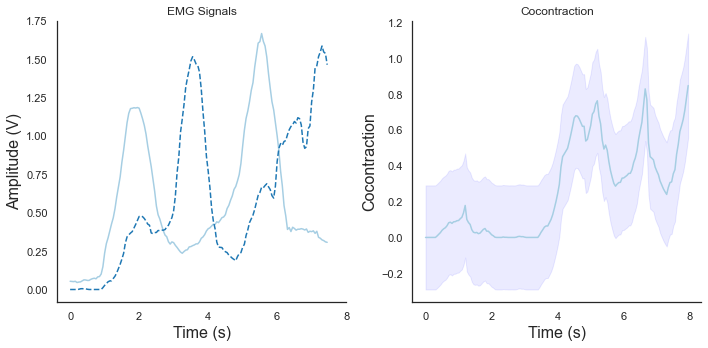

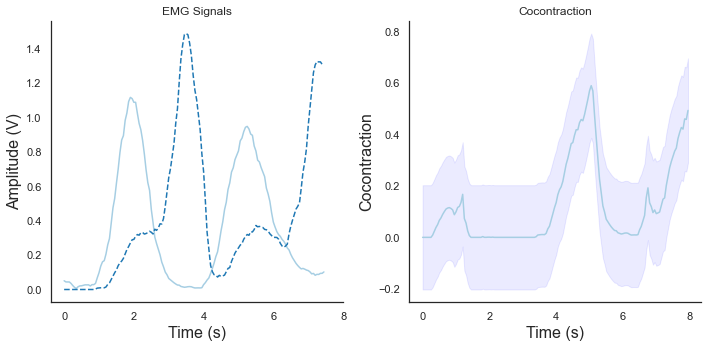

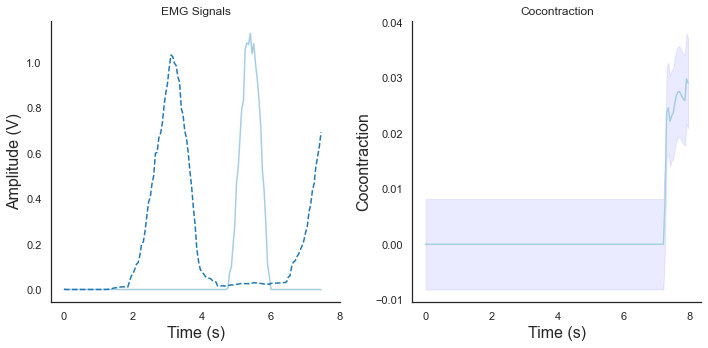

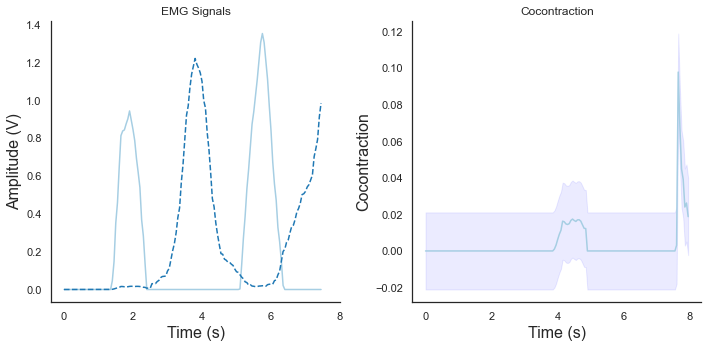

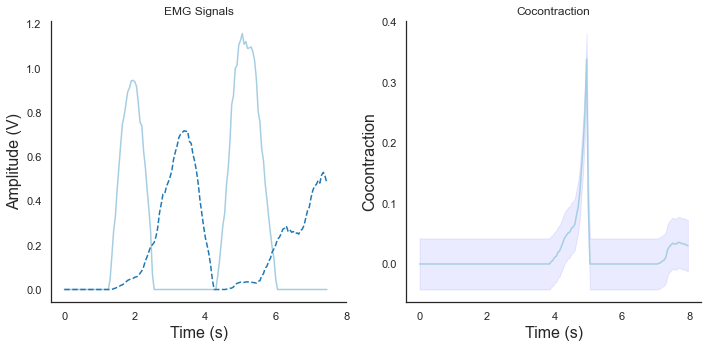

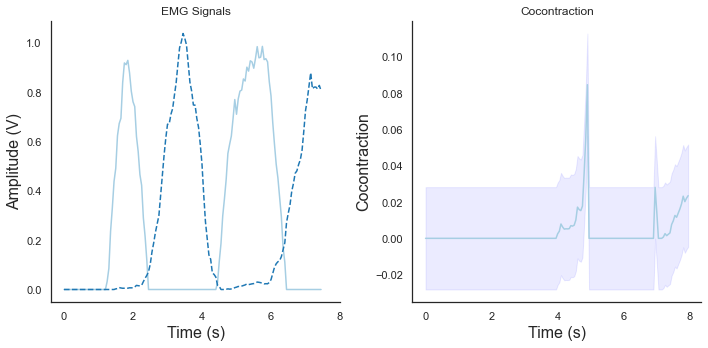

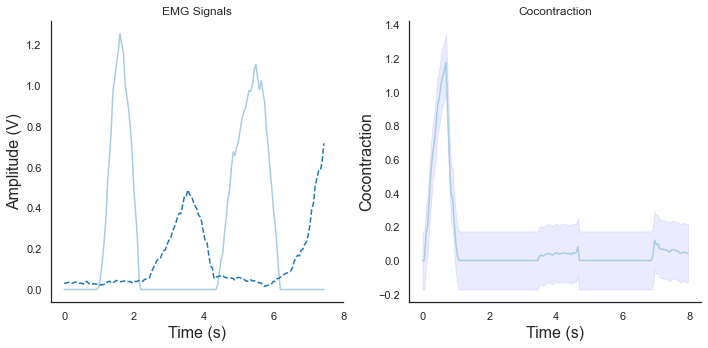

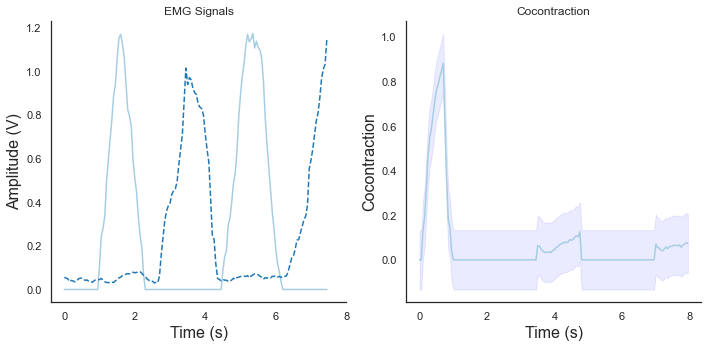

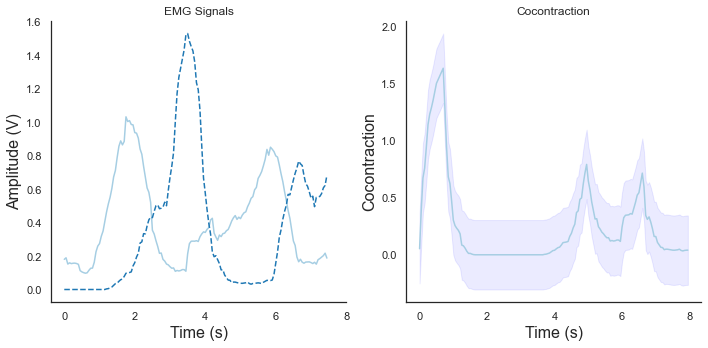

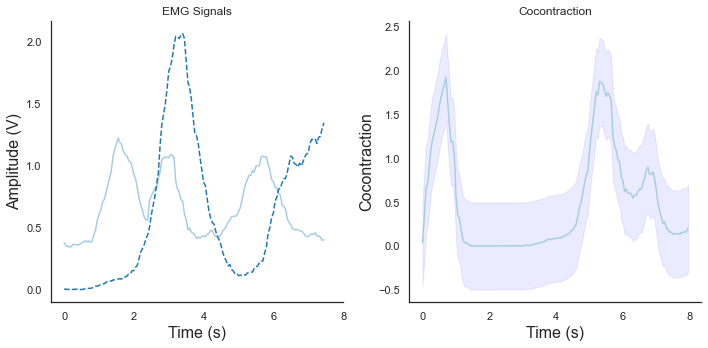

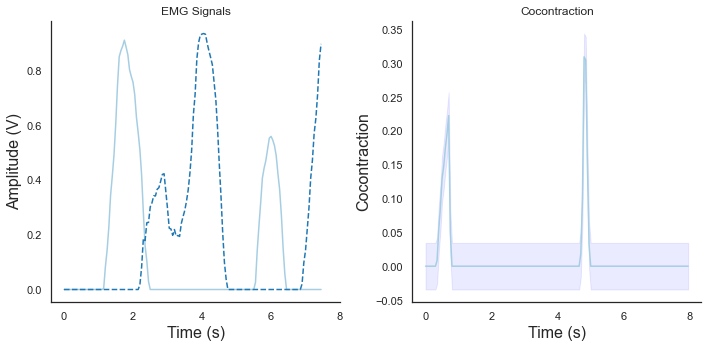

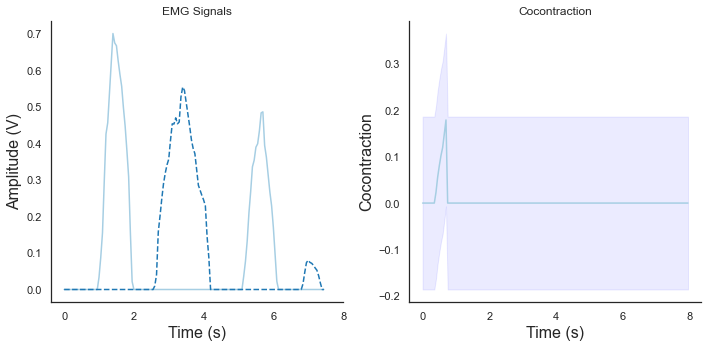

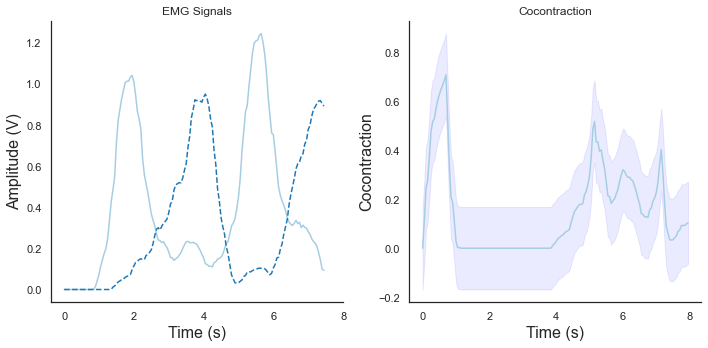

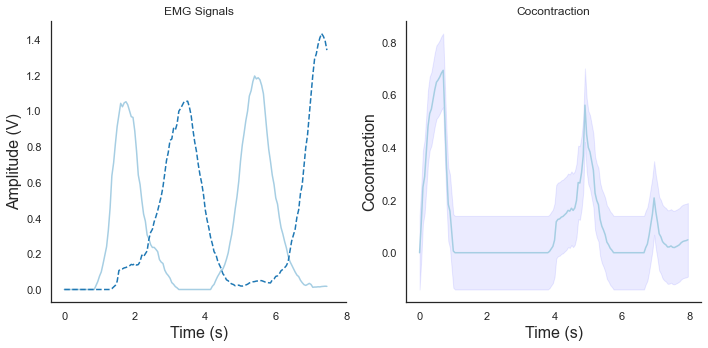

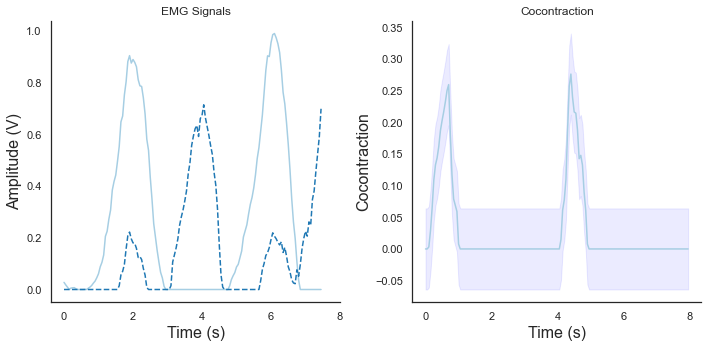

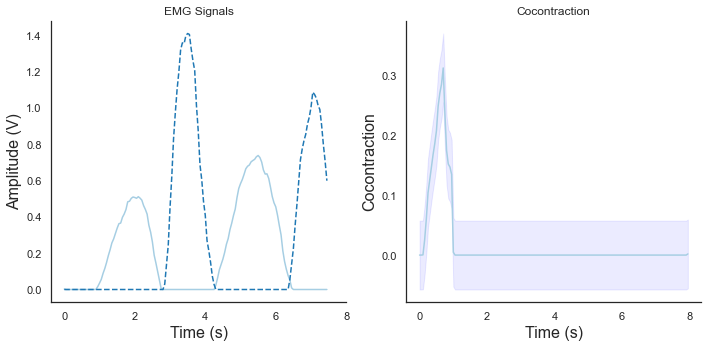

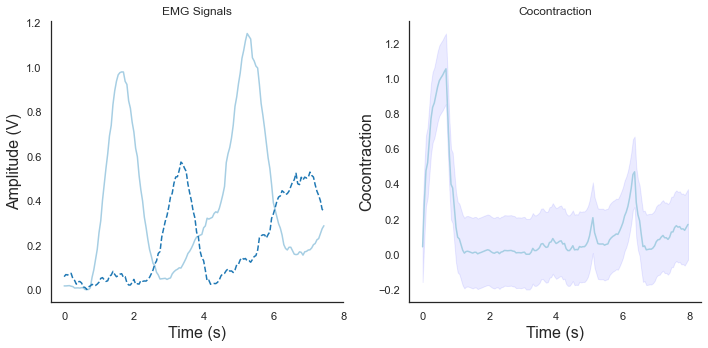

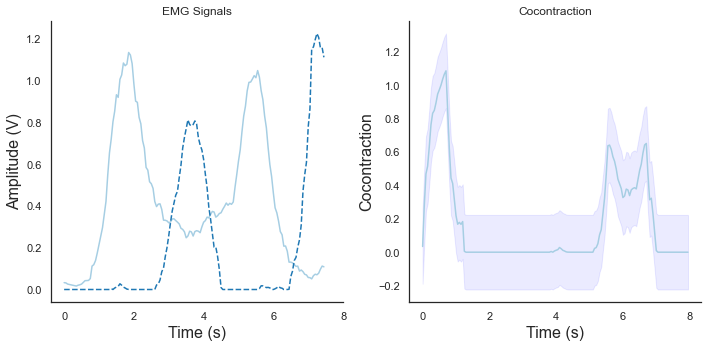

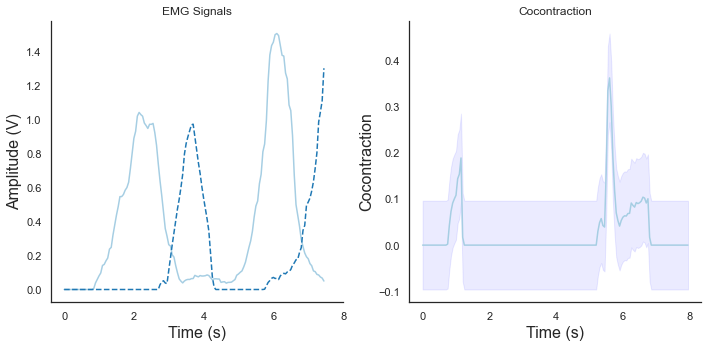

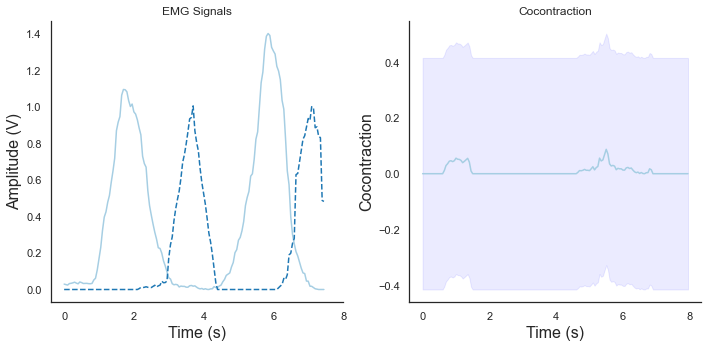

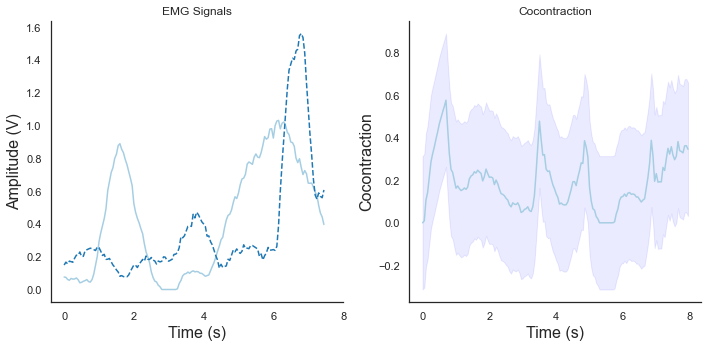

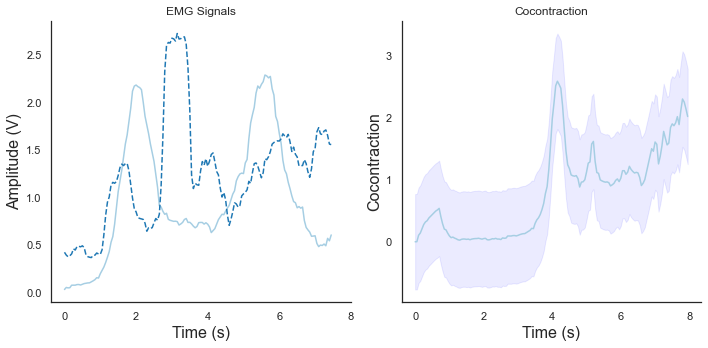

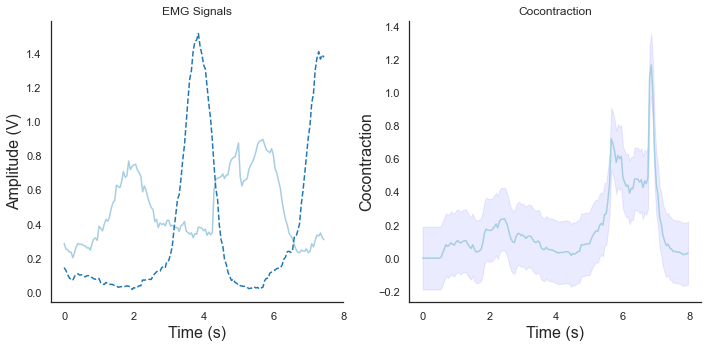

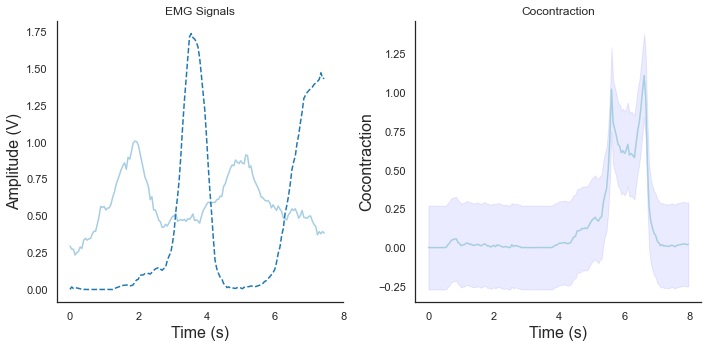

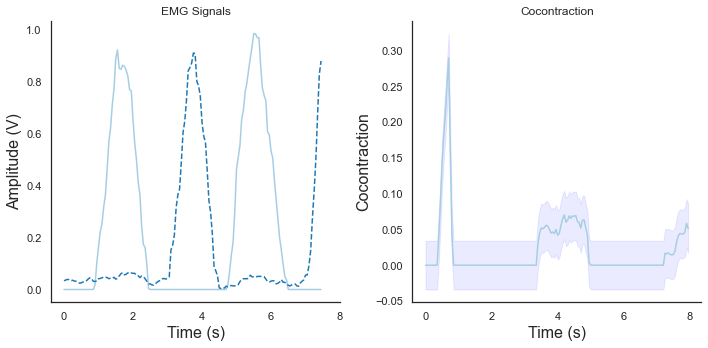

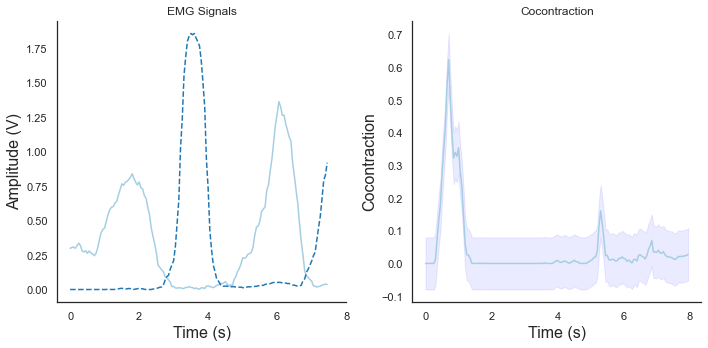

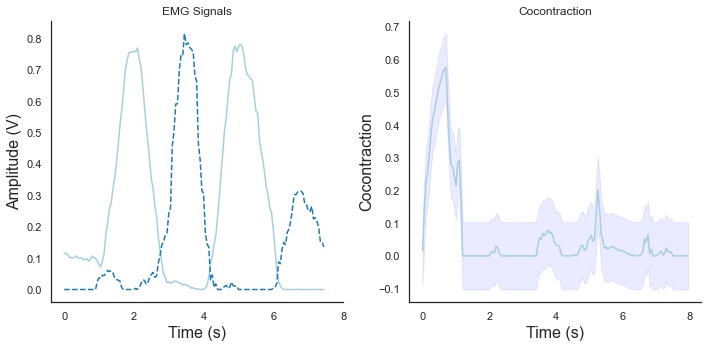

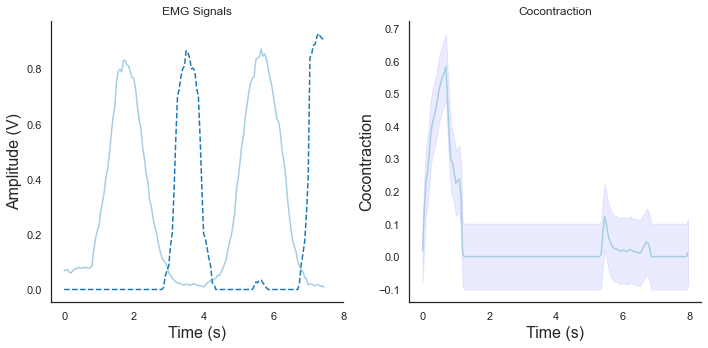

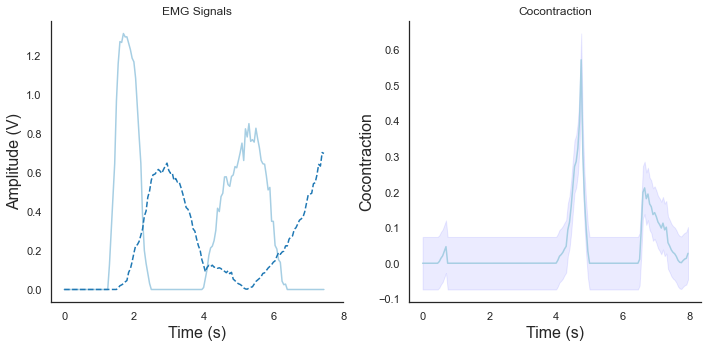

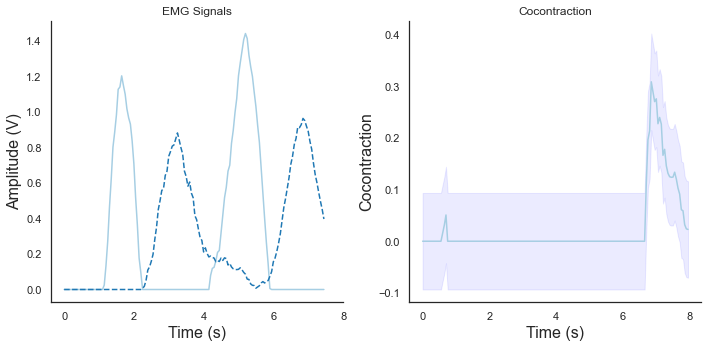

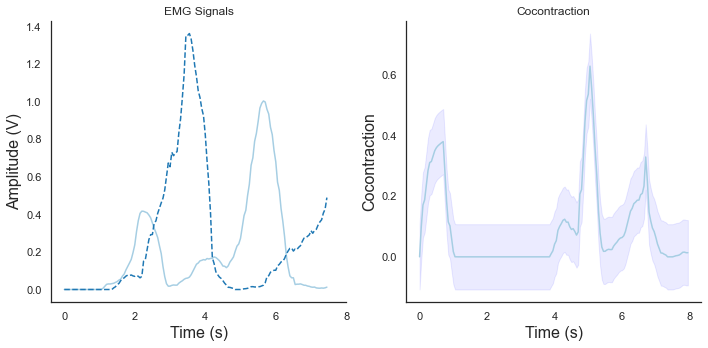

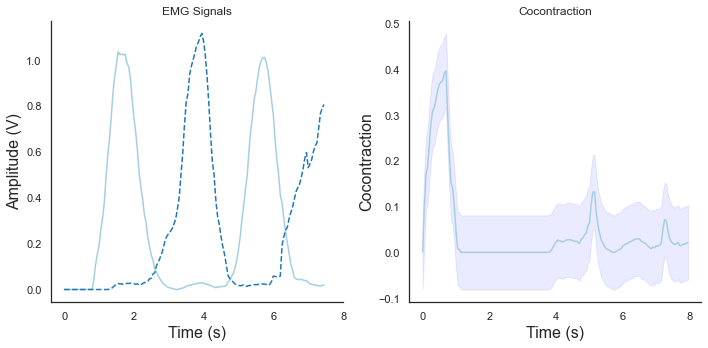

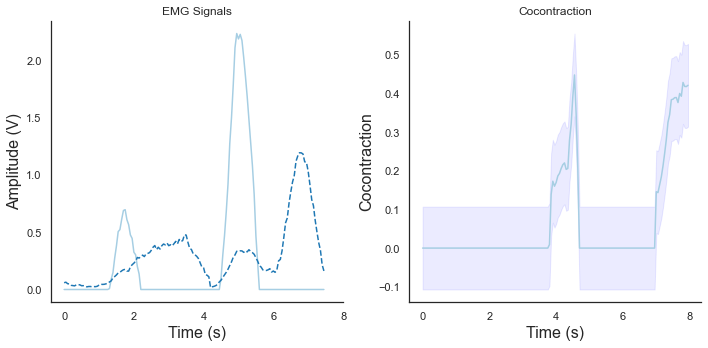

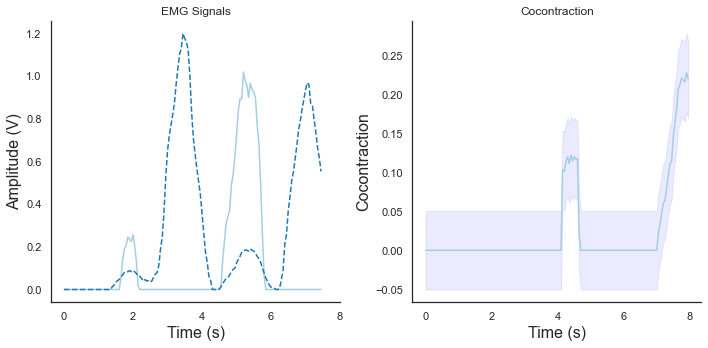

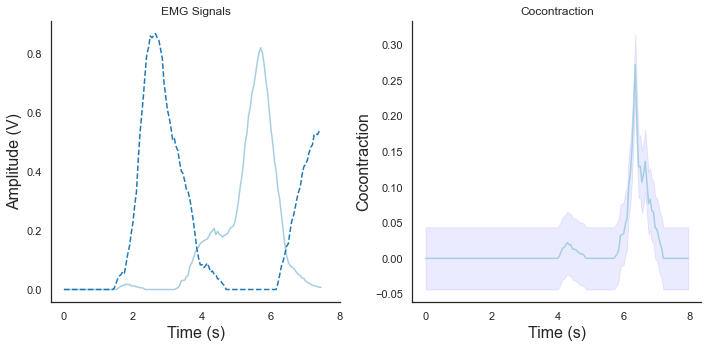

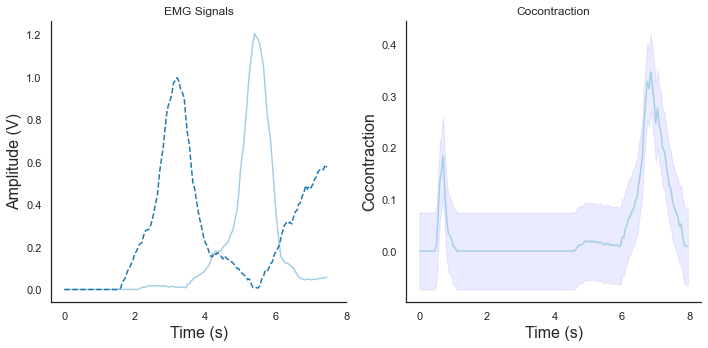

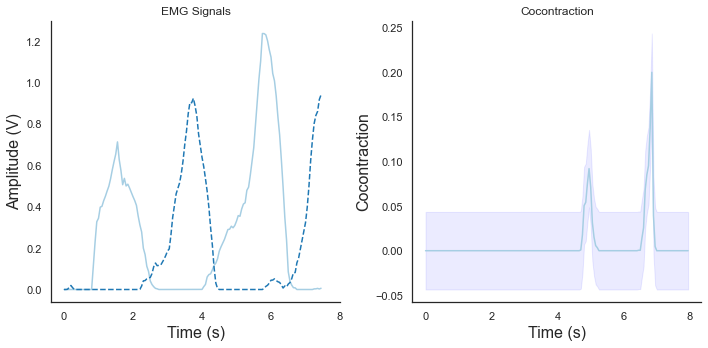

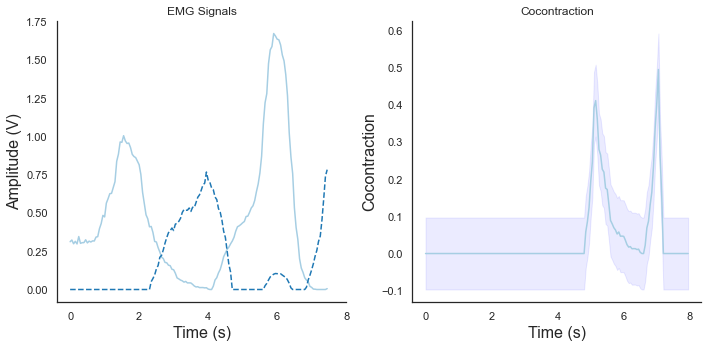

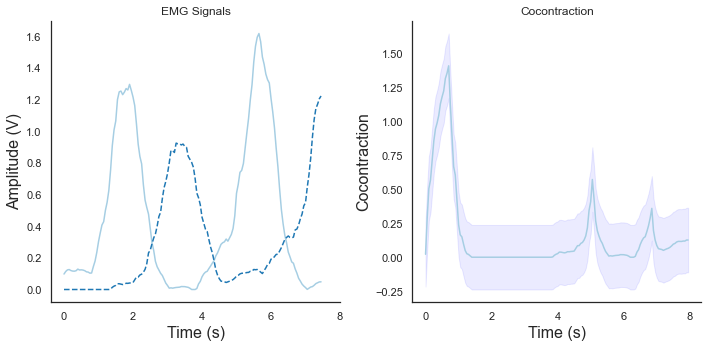

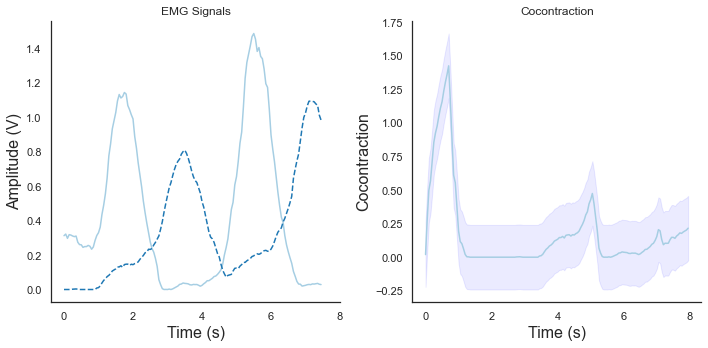

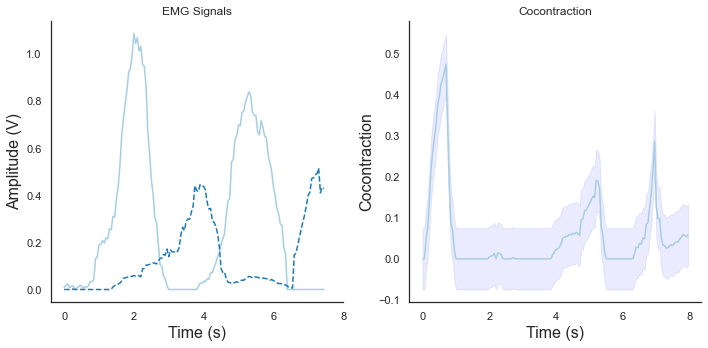

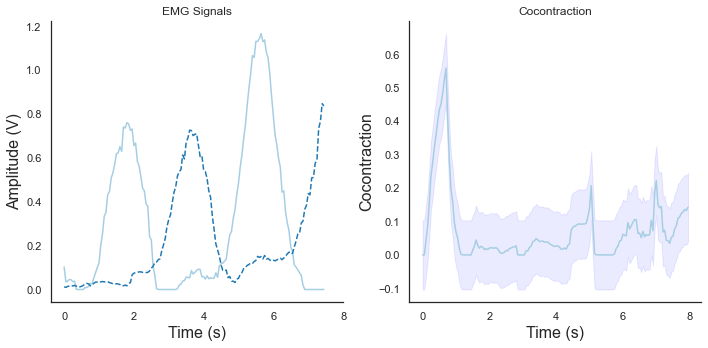

In [5]:
participants = ('SN001', 'SN002', 'SN003', 'SN004', 'SN005', 'SN006', 'SN007', 'SN008', 'SN009', 'SN010', 'SN011', 'SN012', 'SN013', 'SN014', 'SN015', 'SN016', 'SN017', 'SN018', 'SN019', 'SN020', 'SN021')

for p in participants:
    root_subject = os.path.join('data', p)
    control_folders = [f.path for f in os.scandir(root_subject) if f.is_dir() and f.name.startswith('control')]
    
    for b in control_folders:
        if os.path.isfile(os.path.join(b, 'trials.csv')):
            trials = pd.read_csv(os.path.join(b, 'trials.csv'))
            
            if trials["emg"][0] == 1:
                if os.path.isfile(os.path.join(b, 'data_proc.hdf5')):
                    data_proc = h5py.File(os.path.join(b, 'data_proc.hdf5'), 'r')
                    proc_1 = data_proc['1'][0:][0]
                    proc_2 = data_proc['1'][0:][1]
     
                    cocontraction = calculate_cocontraction(proc_1, proc_2)
                    mean_cocontraction = np.mean(cocontraction)
                    std_cocontraction = np.std(cocontraction)
                    
                    plt.figure(figsize=(10, 5))
                    
                    plt.subplot(1, 2, 1)
                    sns.lineplot(data=proc_1[50:200])
                    sns.lineplot(data=proc_2[50:200], linestyle='dashed')
                    plt.xlabel('Time (s)', fontsize=16)
                    plt.ylabel('Amplitude (V)', fontsize=16)
                    plt.xticks(ticks=[0, 40, 80, 120, 160], labels=[0, 2, 4, 6, 8])
                    plt.title('EMG Signals')
                    sns.despine()
                    
                    plt.subplot(1, 2, 2)
                    plt.plot(range(0, 160), cocontraction[0:160], label='Cocontraction')
                    plt.fill_between(range(0, 160), cocontraction[0:160] - std_cocontraction, cocontraction[0:160] + std_cocontraction, color='blue', alpha=0.08)
                    plt.xlabel('Time (s)', fontsize=16)
                    plt.ylabel('Cocontraction', fontsize=16)
                    plt.xticks(ticks=[0, 40, 80, 120, 160], labels=[0, 2, 4, 6, 8])
                    plt.title('Cocontraction')
                    sns.despine()
                    
                    plt.tight_layout()
                    plt.show()


In [6]:
current_directory = os.getcwd()

data = []

participants = ('SN001', 'SN002', 'SN003', 'SN004', 'SN005', 'SN006', 'SN007', 'SN008', 'SN009', 'SN010', 'SN012', 'SN013', 'SN014', 'SN015', 'SN016', 'SN017', 'SN018', 'SN019', 'SN020', 'SN021')

SN=0
for p in participants:
    SN = SN+1
    root_subject = os.path.join('data', p)
    control_folders = [f.path for f in os.scandir(root_subject) if f.is_dir() and f.name.startswith('control')]
    BN = 0
    for b in control_folders:
        fb = []
        BN = BN+1
        if os.path.isfile(os.path.join(b, 'trials.csv')):
            data_temp = pd.read_csv(os.path.join(b, 'trials.csv'),)
            data_temp.insert(0,'BN', BN)
            data_temp.insert(0,'SN',SN)
            data.append(data_temp)

merged_df = pd.concat(data, ignore_index=True)                        

In [7]:
participant_list = []
block_list = []
timepoint_list = []
cocontraction_list = []
noise_level_list = []


for SN, p in enumerate(participants, start=1):
    root_subject = os.path.join('data', p)
    control_folders = [f.path for f in os.scandir(root_subject) if f.is_dir() and f.name.startswith('control')]
    BN = 0
    
    
    for b in control_folders:
        BN += 1
        if os.path.isfile(os.path.join(b, 'trials.csv')):
            trials = pd.read_csv(os.path.join(b, 'trials.csv'))
            
            if trials["emg"][0] == 1:
                noise_level = trials["noise"][0]
                
                if os.path.isfile(os.path.join(b, 'data_proc.hdf5')):
                    data_proc = h5py.File(os.path.join(b, 'data_proc.hdf5'), 'r')
                    proc_1 = np.array(data_proc['1'][:][0])
                    proc_2 = np.array(data_proc['1'][:][1])
                    
                    cocontraction = calculate_cocontraction(proc_1, proc_2)
                    
                    # time_points = np.arange(proc_1.shape[0])
                    
                    participant_list.extend([SN] * len(time_points))
                    block_list.extend([BN] * len(time_points))
                    # timepoint_list.extend(time_points)
                    cocontraction_list.extend(cocontraction)
                    noise_level_list.extend([noise_level] * len(time_points))

flat_results_df = pd.DataFrame({
    'Participant': participant_list,
    'Block': block_list,
    # 'TimePoint': timepoint_list,
    'Cocontraction': cocontraction_list,
    'NoiseLevel': noise_level_list
})

# flat_results_df


In [8]:
# model = ols('Block ~ C(Cocontraction)', data=flat_results_df).fit()
# sm.stats.anova_lm(model, typ=2)